# Logistic Regression vs LogRegCCD on Synthetic Data

In [1]:
import os
if not os.path.exists("./notebooks"):
    %cd ..
    %cd ..

import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import pandas as pd
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from src.log_reg_ccd import LogRegCCD
from src.data.data_loader import SyntheticDataLoader
from src.data.dataset_interface import DataInterface
import src.measures as measure

c:\Users\weron\Pulpit\sem1\aml\projects\proj1\LogRegCCD\notebooks
c:\Users\weron\Pulpit\sem1\aml\projects\proj1\LogRegCCD


## Utils

In [2]:
@dataclass
class ExperimentParams:
    title: str
    n: int
    p: float
    d: int
    g: float
    eps: float = 1e-3
    lam_max: float = 10.0
    lam_count: int = 100
    k_fold: int = 10

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [7]:
def test_model(model, X, y, save_path=None, ccd=True):
    results = {}

    y_pred = model.predict(X)
    if ccd:
        y_pred_proba = model.predict_proba(X)
        results['coefficients'] = model.best_beta
    else:
        y_pred_proba = model.predict_proba(X)[:,1]
        results['coefficients'] = np.concatenate((model.intercept_, model.coef_[0]))

    results['accuracy'] = accuracy_score(y, y_pred)
    results['classification_report'] = classification_report(y, y_pred)
    results['confusion_matrix'] = confusion_matrix(y, y_pred)
    results['auc_roc'] = aucroc(y, y_pred_proba)
    results['balanced_accuracy'] = ba(y, y_pred)

    # print(f"\nCoefficients: {results['coefficients']}")
    # print(f"\n{color.CYAN}{color.UNDERLINE}{aucroc}{color.END}: {results['auc_roc']}")
    # print(f"\n{color.CYAN}{color.UNDERLINE}{ba}{color.END}: {results['balanced_accuracy']}")
    # print(f"\nAccuracy: {results['accuracy']:.4f}")
    # print(f"\nClassification Report:\n{results['classification_report']}")
    # print(f"\nConfusion Matrix:")
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=results['confusion_matrix'])
    disp.plot()

    if save_path:
        with open(save_path, 'w') as f:
            f.write("="*50 + "\n")
            f.write("MODEL EVALUATION RESULTS\n")
            f.write("="*50 + "\n\n")
            
            f.write("COEFFICIENTS:\n")
            f.write(str(results['coefficients']) + "\n\n")
            
            if 'auc_roc' in results:
                f.write(f"AUC-ROC SCORE: {results['auc_roc']:.4f}\n\n")
            
            if 'balanced_accuracy' in results:
                f.write(f"BALANCED ACCURACY: {results['balanced_accuracy']:.4f}\n\n")
            
            f.write(f"ACCURACY: {results['accuracy']:.4f}\n\n")
            
            f.write("CLASSIFICATION REPORT:\n")
            f.write(results['classification_report'] + "\n\n")
            
            f.write("CONFUSION MATRIX:\n")
            np.savetxt(f, results['confusion_matrix'], fmt='%d')
            f.write("\n")
            
            f.write("="*50 + "\n")
        
        plot_path = str(save_path).replace('.txt', '_confusion_matrix.pdf')
        plt.savefig(plot_path, format='pdf', bbox_inches='tight')
    
    plt.close()

## Experiments params

In [8]:
experiments = [
    
    ExperimentParams(title='Default', n=1000, p=0.5, d=10, g=0.1),

    ExperimentParams(title='Few samples', n=100, p=0.5, d=10, g=0.1),
    ExperimentParams(title='Lots of samples', n=10000, p=0.5, d=10, g=0.1),

    ExperimentParams(title='Slightly imbalanced', n=1000, p=0.3, d=10, g=0.1),
    ExperimentParams(title='Highly impalanced', n=1000, p=0.1, d=10, g=0.1),

    ExperimentParams(title='Few features', n=1000, p=0.5, d=5, g=0.1),
    ExperimentParams(title='Lots of features', n=1000, p=0.5, d=100, g=0.1),

    ExperimentParams(title='Moderate correlation', n=1000, p=0.5, d=10, g=0.5),
    ExperimentParams(title='Strong correlation', n=1000, p=0.5, d=10, g=0.9),

]

## Experiment choice

In [9]:
random_seed = 42
chosen_experiment = 'Default'
results_main_dir = 'synthetic_data'

In [10]:
results_dir = os.path.join('results', os.path.join(results_main_dir, chosen_experiment))
os.makedirs(results_dir, exist_ok=True)

experiment = next(exp for exp in experiments if exp.title == chosen_experiment)
aucroc = measure.AUCROC()
ba = measure.BalancedAccuracy()

In [ ]:
def ex(experiment):

    results_dir = os.path.join('results', os.path.join(results_main_dir, experiment.title))
    os.makedirs(results_dir, exist_ok=True)

    di = DataInterface(SyntheticDataLoader(experiment.p, experiment.n, experiment.d, experiment.g, random_seed))
    di.split_data(val_size=0.2, test_size=0.3)
    data = di.get_data()
    X_train, y_train = data['train_data'], data['train_labels']
    X_valid, y_valid = data['val_data'], data['val_labels']
    X_test, y_test = data['test_data'], data['test_labels']

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(penalty=None)
    model.fit(X_train, y_train)
    test_model(model, X_test, y_test, os.path.join(results_dir, 'sklearn_metrics.txt'), False)

    model_ccd = LogRegCCD(verbose=False)
    model_ccd.fit(X_train, y_train, experiment.eps, experiment.lam_max, experiment.lam_count, experiment.k_fold)
    test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_metrics.txt'))

    fig = model_ccd.plot(X_valid, y_valid, measure=aucroc)
    fig.savefig(os.path.join(results_dir, 'logregccd_aucroc.pdf'), format='pdf', bbox_inches='tight')
    plt.close(fig)
    model_ccd.validate(X_valid, y_valid, measure=aucroc)
    test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_aucroc_metrics.txt'))

    fig = model_ccd.plot(X_valid, y_valid, measure=ba)
    fig.savefig(os.path.join(results_dir, 'logregccd_ba.pdf'), format='pdf', bbox_inches='tight')
    plt.close(fig)
    model_ccd.validate(X_valid, y_valid, measure=ba)
    test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_ba_metrics.txt'))

for idx, exp in enumerate(experiments):
    ex(exp)
    

C:\Users\weron\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\weron\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\weron\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Data loading

In [8]:
di = DataInterface(SyntheticDataLoader(experiment.p, experiment.n, experiment.d, experiment.g, random_seed))
di.split_data(val_size=0.2, test_size=0.3)
data = di.get_data()
X_train, y_train = data['train_data'], data['train_labels']
X_valid, y_valid = data['val_data'], data['val_labels']
X_test, y_test = data['test_data'], data['test_labels']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## LogisticRegression


Coefficients: [ 0.04895156  3.33080161 -1.20351234 -0.82914132 -0.42978342  0.029961
  0.18916221  0.38800177 -0.26289354 -0.22108733  0.21599341]

AUC ROC: 0.8727030033370411

Balanced accuracy: 0.7769744160177976

Accuracy: 0.7767

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       155
           1       0.76      0.79      0.77       145

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

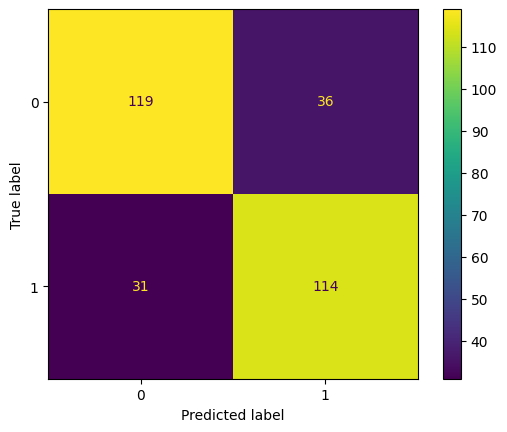

In [9]:
model = LogisticRegression(penalty=None)
model.fit(X_train, y_train)
test_model(model, X_test, y_test, False, os.path.join(results_dir, 'sklearn_metrics.txt'))

## LogRegCCD


Coefficients: [ 2625.14124881 56447.47855649     0.         -3258.29301875
    -0.            -0.             0.             0.
    -0.             0.             0.        ]

AUC ROC: 0.7406006674082314

Balanced accuracy: 0.7406006674082313

Accuracy: 0.7400

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       155
           1       0.72      0.76      0.74       145

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

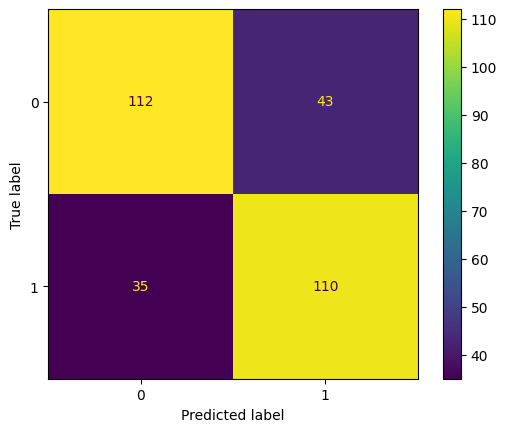

In [10]:
model_ccd = LogRegCCD(verbose=False)
model_ccd.fit(X_train, y_train, experiment.eps, experiment.lam_max, experiment.lam_count, experiment.k_fold)
test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_metrics.txt'))

### AUC ROC


Coefficients: [0.01428908 0.03017683 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]

AUC ROC: 0.7998665183537264

Balanced accuracy: 0.6983314794215796

Accuracy: 0.6933

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.55      0.65       155
           1       0.64      0.85      0.73       145

    accuracy                           0.69       300
   macro avg       0.72      0.70      0.69       300
weighted avg       0.72      0.69      0.69       300


Confusion Matrix:


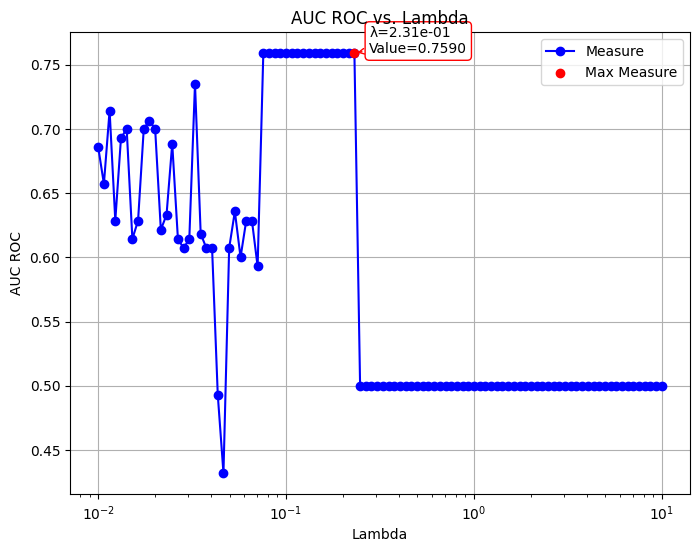

<Figure size 640x480 with 0 Axes>

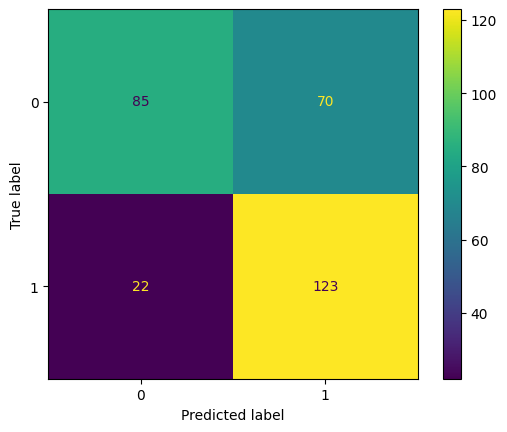

In [ ]:
fig = model_ccd.plot(X_valid, y_valid, measure=aucroc)
fig.savefig(os.path.join(results_dir, 'logregccd_aucroc.pdf'), format='pdf', bbox_inches='tight')
plt.show(fig)
model_ccd.validate(X_valid, y_valid, measure=aucroc)
test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_aucroc_metrics.txt'))

### Balanced Accuracy

In [ ]:
fig = model_ccd.plot(X_valid, y_valid, measure=ba)
fig.savefig(os.path.join(results_dir, 'logregccd_ba.pdf'), format='pdf', bbox_inches='tight')
plt.show(fig)
model_ccd.validate(X_valid, y_valid, measure=ba)
test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_ba_metrics.txt'))